# MNIST 손글씨 - CNN ver 3
- 2 x Conv2D layers
- MaxPooling2D layer
-  1 FCN layer
- 1 Output layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) =  mnist.load_data() # 데이터 자체에 튜플형식으로 들어가 있음 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
# X_train, X_test 정규화(0~1)
# 이미지 차원 변경 
X_train = X_train.reshape(-1, 28,28,1) / 225.
X_test = X_test.reshape(-1, 28,28,1) / 225.

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [4]:
# one-hot encodig
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

2. 모델 정의/설정/학습/평가

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
model = Sequential([
                    Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'), # 마스크 개수, 마스크 사이즈 
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(),                       # MaxPooling2D(pool_size=(2,2))
                    Dropout(0.25),
                    Flatten(),                            # ----> 1 차원 변경 
                    Dense(512, activation='relu'),
                    Dropout(0.5),
                    Dense(10, activation='softmax')       # feature col num = 10 이여서 

])
model.summary()
## Output Shape 
# (input 개수 + 2 * 패딩 개수 -f/ stride 개수) + 1
# shape 1: (28 + 0 - 3) /1 + 1 = 26  ---> (26, 26, 32)
# shape 2: (26 + 0 - 3) /1 + 1 = 24  ---> (24, 24, 64)

## 파라미터 개수
# 입력채널 수 x 마스크 폭 x 마스크 높이 x 출력채널 수(노드개수) + 출력채널 수
# conv2d_2: 32 x 3 x 3 x 64 + 64 = 18496

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                        

In [13]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = 'best-mnist-cnn-v3.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10) 

In [14]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=100, batch_size=200,
    callbacks=[mc,es]
)
# flatten -> FCN 넘어갈 때 파라미터 수 많아져서 일반 cpu로 돌리면 시간 너무 오래걸림!
# 학습시에 GPU로 변경 후 실행하기 

Epoch 1/100
238/240 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9336
Epoch 1: val_loss improved from inf to 0.05568, saving model to best-mnist-cnn-v3.h5
240/240 [==============================] - 14s 15ms/step - loss: 0.2138 - accuracy: 0.9339 - val_loss: 0.0557 - val_accuracy: 0.9837
Epoch 2/100
236/240 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9815
Epoch 2: val_loss improved from 0.05568 to 0.05067, saving model to best-mnist-cnn-v3.h5
240/240 [==============================] - 4s 15ms/step - loss: 0.0604 - accuracy: 0.9816 - val_loss: 0.0507 - val_accuracy: 0.9858
Epoch 3/100
240/240 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9869
Epoch 3: val_loss improved from 0.05067 to 0.03894, saving model to best-mnist-cnn-v3.h5
240/240 [==============================] - 3s 14ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0389 - val_accuracy: 0.9894
Epoch 4/100
238/240 [============================

In [15]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0301 - accuracy: 0.9912


[0.03009832464158535, 0.9911999702453613]

3. 학습 과정 시각화

In [16]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs =np.arange(1, len(y_acc)+1) # 시작을 1번부터 해주기 위해서

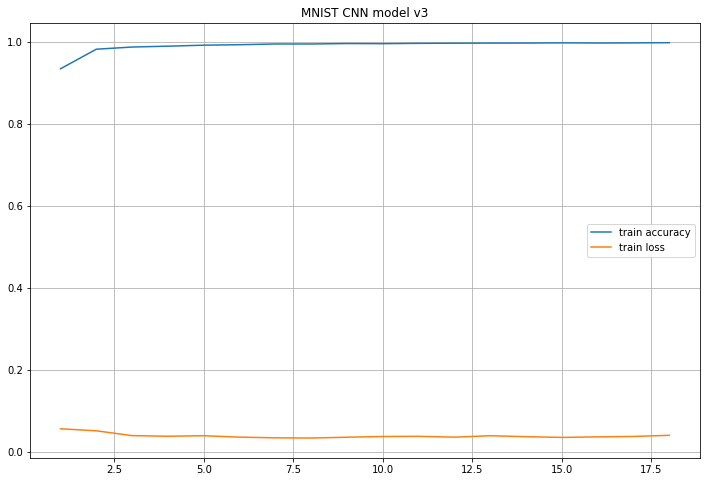

In [17]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='train loss')
plt.legend(), plt.grid()
plt.title('MNIST CNN model v3')
plt.show()